# PHYS20762 - Project 3

Dominik Szablonski <br>
11310146 <br>
University of Manchester <br>
March 2025

In [1]:
# Importing libraries

import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.constants import N_A
import string
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import textwrap
from tqdm.notebook import tnrange
from IPython.display import display, Markdown
from ipywidgets import IntProgress

def markdown(markdown):
    """
    Function to allow for the displaying of Python output as markdown
    text. 

    Parameters
    ----------
    markdown: string
        String to be displayed.

    Returns
    -------
    None
    """
    
    display(Markdown(textwrap.dedent(markdown)))

plt.style.use('seaborn-v0_8-darkgrid')

s = time.time()

# 1. Introduction
Monte Carlo methods utilise random sampling to solve deterministic problems. The invention of the first modern Monte Carlo method is credited to Stanislaw Ulam while he was working at Los Alamos National Laboratory during the second world war <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). This project concerns using a Monte Carlo simulation in order to model water, lead, and graphite subject to a neutron beam. Using these simulations, we can obtain the characteristic attenuation length for each material by considering the reflection, absorption, and transmission rates for each material.

## 1.1. Goals
- Generate randomly distributed points in 3 dimensions, alleviating any spectral issues.
- Create a random number generator which generates numbers according to $\exp(-x/\lambda)$.
- Write a function which produces isotropic unit vector.
- Write a function which generates isotropic steps with lengths distributed exponentially.
- Determine the material properties of water, lead, and graphite.
- Visualise the random walk of a neutron in 10cm of each material.
- Quantify the scattering process within each material by calculating the reflection, absorption, and transmission rates for neutrons in each material.
- Plot the variation of these rates against slab thickness.
- Determine the attenuation lengths for each material.
- **STRETCH:** Compute the reflection, absorption, and transmission rates of neutrons through two adjacent materials using the woodcock method.

## 1.2. Introduction to the Monte Carlo Method
Monte Carlo methods are a class of computer algorithms which rely on repeated random sampling in order to obtain a numerical result. These types of algorithms are continually used in solving complex problems within physics, finance, and other areas.

This project involves the modelling of neutron shielding in different materials. The processes involved in neutron shielding are chaotic, however, properties such as the mean free path within a given material are in principle deterministic. Thus, it is best to approach this problem using Monte Carlo methods.

## 1.3. Material Properties
In order to perform our simulation, we must first know some of the properties of our material. The ones we require are shown in the table below.

|   |Water|Lead|Graphite|
|---|---|---|---|
|Absorption Cross Section, $\sigma_a$ (barn)|0.6652|0.158|0.0045|
|Scattering Cross Section, $\sigma_s$ (barn)|103.0|11.221|4.74|
|Density, $\rho$ (g cm$^{-3}$)|1.00|11.35|1.67|
|Molar Mass, $M$ (g mol$^{-1}$)|18.0153|207.2|12.011|

From this data, we can make a good guess/estimate that water will perfrom best at neutron shielding. We can gather this by simply inspecting the data in the table above, with water having the greatest absorption and scattering cross section out of all three materials. Furthermore, in real applications, water is often used as a moderator for neutron shielding, due to being hydrogen-rich <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2). 

Lead's low absorption cross section is primarily due to its high density. Additioanly lead is primarily used as a coolant in lead-cooled fast reactors <a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3). Lead is a good material for these types of reactors as it does not moderate (i.e., slow down) neutrons significantly, and act as a reflector for neutrons, directing them back into the core. Graphite has an even lower absorption cross-section, and is often used as a moderator within nuclear reactors <a name="cite_ref-4"></a>[<sup>[4]</sup>](#cite_note-4).

### 1.3.1 Closer Look at Neutron Interactions
Let us develop some theory behind neutron absorption within materials. Suppose a slab of material of thickness $L$. The number density within the material is given by,
$$n = \frac{\rho N_A}{M}$$
where $\rho$ is the density of the material, $N_A$ is Avogadros number, and $M$ is the molar mass of the material. Within the material, there are molecules with which the neutrons may collide with which may causes some interaction. Let's suppose that if a neutron collides with a group of these molecules, bundled together to form a shape with a mean cross section $\sigma_a$, then it will be absorbed. The number of neutrons absorbed will be given by,
$$N_L = n\sigma_aIL,$$
where $I$ is the intensity of the neutron beam. The rate of absorption per unit thickness is given by,
$$R = -\frac{\text{d}I}{\text{d}x}=n\sigma I,$$
and by solving this equation, the intensity variation with thickness is given by,
$$I(x) = e^{-n\sigma_a x}.$$
It is then useful to define a single parameter to encode the behaviour of the neutron within the slab. We can deam $\sigma_a$ as a microscopic cross section, and then define a macroscopic cross section,
$$\Sigma_a = n\sigma_a,$$
with units of inverse distance. From this, we can define a mean free path,
$$\lambda = \frac{1}{\Sigma_a},$$
which will be the mean distance which a neutron can move before it is absorbed within the material. We can then rewrite the intensity profile as,
$$I(x) = e^{-\frac{x}{\lambda}}.$$
However, absorption isn't the only process which can occur within a material. In general, for $N$ processes, if we denote the macroscopic cross section for each process as $\Sigma_1, \Sigma_2, \cdots, \Sigma_i$, then we can write the total macroscopic cross section as,
$$\Sigma_T = \sum_i^N\Sigma_i.$$
We can then find the probability for a given process to occur by,
$$P_i = \frac{\Sigma_i}{\Sigma_T}.$$
We will discuss how to utilise these probablities within our simulation later when we discuss the Markov Chain Monte Carlo method.

If we now look back to the above table, we can see that our program will consider absorption and scattering of thermal neutrons within each material. Let us initialise these parameters within a tuple, and write a function in order to calculate the macroscopic cross section of each material. 

In [2]:
WATER_VALS = (0.6652e-24, 103.0e-24, 1.00, 18.0153)
LEAD_VALS = (0.158e-24, 11.221e-24,  11.35, 207.2)
GRAPHITE_VALS = (0.0045e-24, 4.74e-24, 1.67, 12.011)

def cross_section(sigma, density, molar_mass):
    """
    Function to calculate macroscopic cross section.
    sigma: array
        Array of microscopic cross sections.
    desnity: float
        Density of material.
    molar_mass: float
        Molar mass of material.

    Returns
    -------
    macro: float
        Macroscopic cross section.
    """
    
    macro = (((N_A*density)/molar_mass)*(np.sum(sigma)))

    return macro

# Calculating all required cross sections.
water_csc = cross_section([WATER_VALS[0], WATER_VALS[1]], WATER_VALS[2], WATER_VALS[3])
lead_csc = cross_section([LEAD_VALS[0], LEAD_VALS[1]], LEAD_VALS[2], LEAD_VALS[3])
graphite_csc = cross_section([GRAPHITE_VALS[0], GRAPHITE_VALS[1]], GRAPHITE_VALS[2], GRAPHITE_VALS[3])

water_abs_csc = cross_section([WATER_VALS[0]], WATER_VALS[2], WATER_VALS[3])
lead_abs_csc = cross_section([LEAD_VALS[0]], LEAD_VALS[2], LEAD_VALS[3])
graphite_abs_csc = cross_section([GRAPHITE_VALS[0]], GRAPHITE_VALS[2], GRAPHITE_VALS[3])

water_sca_csc = cross_section([WATER_VALS[1]], WATER_VALS[2], WATER_VALS[3])
lead_sca_csc = cross_section([LEAD_VALS[1]], LEAD_VALS[2], LEAD_VALS[3])
graphite_sca_csc = cross_section([GRAPHITE_VALS[1]], GRAPHITE_VALS[2], GRAPHITE_VALS[3])

water_att = 1/water_csc
lead_att = 1/lead_csc
graphite_att = 1/graphite_csc

attenuation_string = rf"""
||Water|Lead|Graphite|
|---|---|---|---|
|$\Sigma_T/\text{{cm}}^{{-1}}$|{water_csc:.4f}|{lead_csc:.4f}|{graphite_csc:.4f}|
|$\lambda/\text{{cm}}$|{water_att:.4f}|{lead_att:.4f}|{graphite_att:.4f}|
|$\Sigma_A/\text{{cm}}^{{-1}}$|{water_abs_csc:.4f}|{lead_abs_csc:.4f}|{graphite_abs_csc:.4f}|
|$\Sigma_S/\text{{cm}}^{{-1}}$|{water_sca_csc:.4f}|{lead_sca_csc:.4f}|{graphite_sca_csc:.4f}|
"""

markdown(attenuation_string)


||Water|Lead|Graphite|
|---|---|---|---|
|$\Sigma_T/\text{cm}^{-1}$|3.4653|0.3754|0.3973|
|$\lambda/\text{cm}$|0.2886|2.6640|2.5172|
|$\Sigma_A/\text{cm}^{-1}$|0.0222|0.0052|0.0004|
|$\Sigma_S/\text{cm}^{-1}$|3.4431|0.3702|0.3969|


# 2. Random Statistics
## 2.1. Pseudo-Random Number Generators
Monte Carlo methods rely on the sampling of random numbers. It is usually impossible for a computer to generate a completely random number, thus we often use pseudo-random number generators. The most common form of pseudo-random number generators are *linear congruential generators* (LCGs), which take the form,
$$X_{n+1} = (aX_n + c)\mod m$$
where each parameter is defined, and has a given bound,
\begin{align}
0 \leq m && \text{Modulus}\\
0 \leq a \leq m && \text{Multiplier}\\
0 < c < m && \text{Increment}\\
0 \leq X_0 \leq m && \text{Seed}\\
\end{align}
By choosing these parameters, we can generate sequences of numbers which have no correlation with each other. This sequence will begin to repeat after $m$ steps. Furthermore, we can generate random, uniformly distributed, floating point numbers up to a precision $m$ by,
$$S_n = \frac{X_n}{m} \in \left[0,1\right].$$
## 2.2. Numpy Random Numbers
We will now inspect NumPys uniform random number generator. Below, 4 histograms are generated for increasing sample sizes randing from $10^2$ to $10^5$ samples. Lines are shown representing the mean and standard deviation of the data, as well as a line plotting the theoretical uniform PDF of form,

$$ f(x) = \begin{cases} 1 & 0 < x < 1 \\
0 & \text{elsewhere}\end{cases}.$$

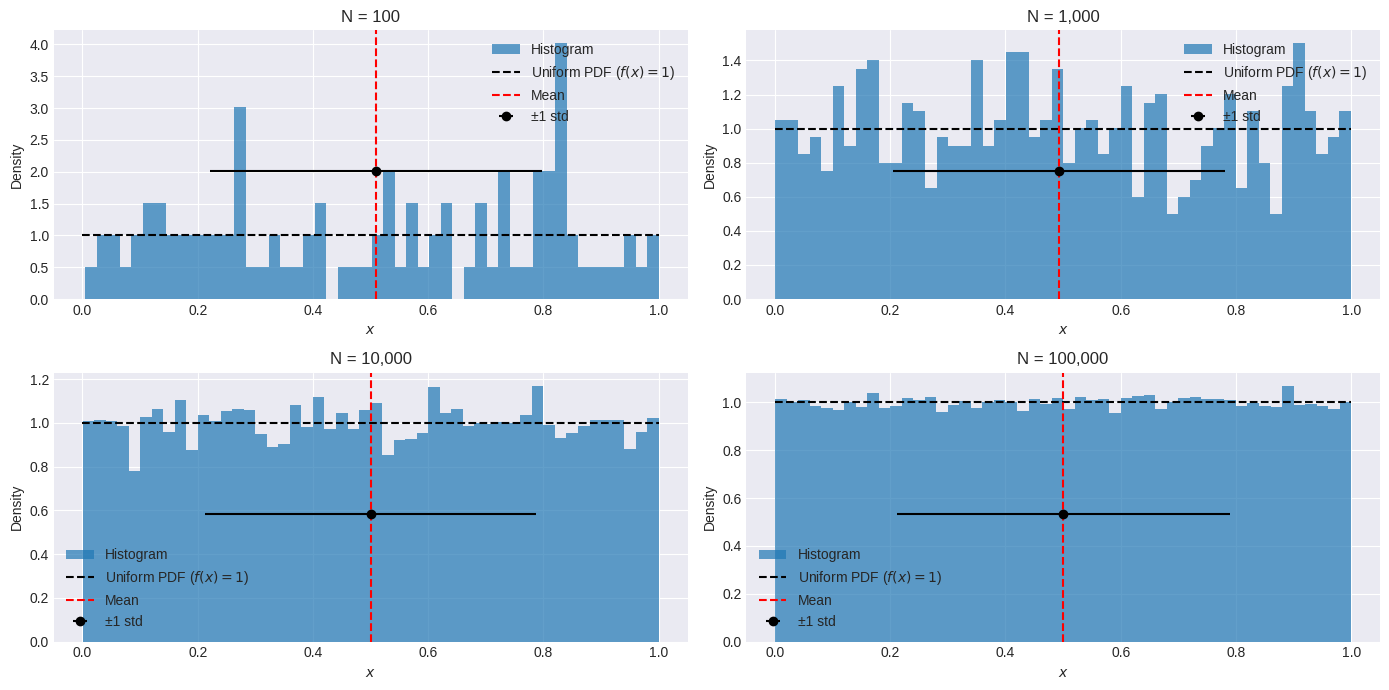

In [3]:
# Define sample sizes
Ns = [10**2, 10**3, 10**4, 10**5]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14,7))
axes = axes.flatten()  # Flatten 2D array to 1D for looping

for ax, N in zip(axes, Ns):
    data = np.random.uniform(size=N)
    mean = np.mean(data)
    std = np.std(data)
    
    counts, bins, _ = ax.hist(data, bins=50, alpha=0.7, density=True, label="Histogram")
    
    # Theoretical uniform PDF line
    ax.plot([0, 1], [1, 1], 'k--', label='Uniform PDF ($f(x)=1$)')
    
    # Plot mean and error bar
    ax.axvline(mean, color='r', linestyle='--', label='Mean')
    ax.errorbar(mean, max(counts) * 0.5, xerr=std, fmt='o', color='black', label='±1 std')
    
    ax.set_title(f"N = {N:,}")
    ax.set_xlabel("$x$")
    ax.set_ylabel("Density")
    ax.legend(loc="best")

plt.tight_layout()
plt.show()

We clearly see that the `random.uniform()` produces a uniform distribution with a consistent mean of $0.50$ and standard deviation of $0.29$ between data points. Furthermore, as we increase the sample size, the function matches the theoretical uniform distribution more closely.

## 2.3. Random Numbers in Higher Dimensions
Not all LCGs perform as well as each other, particularly when it comes to generating numbers in higher dimensions. There exists a theorem known as Marsaglias' theorem which states that improper choice of parameters for an LCG results in numbers generated to lie on equally spaced hyperplanes <a name="cite_ref-5"></a>[<sup>[5]</sup>](#cite_note-2). A particularly bad example is of the RANDU algorithm, where generated points begin exhibiting this behaviour in 3 dimensions, such that points lie on equally spaced, 2D planes. If we were to design our own LCG algorithm, we would likely perform a spectral test, such as the one suggested by Knuth <a name="cite_ref-6"></a>[<sup>[6]</sup>](#cite_note-3). However, for our purpose, we will simply inspect NumPy's uniform random number generator function in 3D to see if any spectral issues occur.

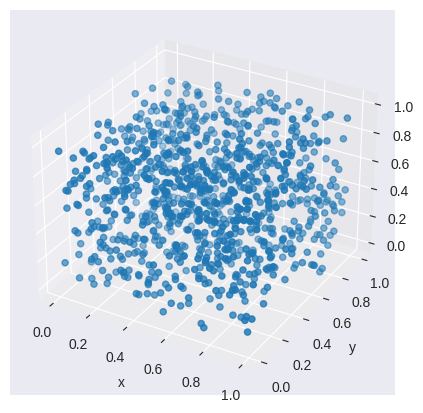

In [4]:
# Generate matrix of points
space = np.random.uniform(size=(3, 1000))
x_uniform = space[0]
y_uniform = space[1]
z_uniform = space[2]

# Plot points
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111,projection='3d')
ax.scatter(x_uniform,y_uniform,z_uniform)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

We clearly do not observe any hyperplanes in our data.

## 2.4. Non-Uniform Distributions
We have previously stated that LCGs produce uniformly distributed random numbers. However, we often want numbers which are not uniformly distributed, for example, when we want our data to be distributed according to a Gaussian distribution, or an exponential distribution. There are many methods of generating numbers which are distributed according to a Gaussian from a set of uniformly distributed numbers, such as by the central limit theorem or the Box-Muller transformation. However, a more general method is *inverse distribution sampling*.

### 2.4.1 Inverse Distribution Sampling
Inverse distribution sampling works by integrating the probability density function (PDF), $P(x)$, of the distribution you wish to samply, and inverting it in order to obtain the *inverse cumulative distribution function* (inverse CDF). By inputting a uniformly distributed variable into the inverse CDF, we retrieve the orginal PDF.

For our case, we wish for our neutrons to be distributed exponentially according to the intensity profile,

$$I(x) = e^{-\frac{x}{\lambda}}.$$

If we write $I(x) = \text{pdf}(x)$, then,

$$\text{cdf}(x) = \int_0^{x}\text{pdf}{x'}\text{d}x' = \int_0^{x}e^{-\frac{x'}{\lambda}}\text{d}x' = \lambda\left[1 - e^{-\frac{x}{\lambda}}\right],$$

and the inverse CDF will be given by,

$$\text{cdf}^{-1}(x) = -\lambda\ln(1-x).$$

We can simplify the expression above, by treating $1-x = u_i$ as just another random number. Thus, our final expression will be,

$$x_i = -\lambda\ln(u_i),$$

where $u_i$ is a uniformly distributed random number $0 \leq u_i \leq 1$, and $\lambda$ is the mean free path.

Let us now write this function in the cell below.

In [5]:
def exponential_generator(samples, free_path):
    """
    Generates random numbers according to an exponential distribution.
    
    Parameters
    ----------
    samples: int
        Number of values generated.
    free_path: float
        Mean free path of a given process.

    Returns
    -------
    x: float
        Exponentially distributed random variable.
    """
    
    u = np.random.uniform(size=samples)
    x = -free_path*np.log(u)

    return x

Let's confirm that this distribution behaves as expected. We will do this by modelling the motion of a neutron through a slab of water of infinite length, where the only interaction which occurs is absorption.

We can pass the corresponding mean free path for absorption into the `exponential_generator` function. We will generate 10 sets of data, simulating 10000 neutrons. Given the large amount of data, we will generate a histogram for each data set. We can then take a mean and standard deviation on the frequency of each bin. If we then take a log on the mean of the frequency, we should be able to extract the attenuation length input to within a single standard deviation by fitting a straight line to the data. We can propagate the error/standard deviation of each bin to the log of the data by,

$$\sigma_{\ln(x)} = \left|\frac{\sigma_x}{x}\right|.$$

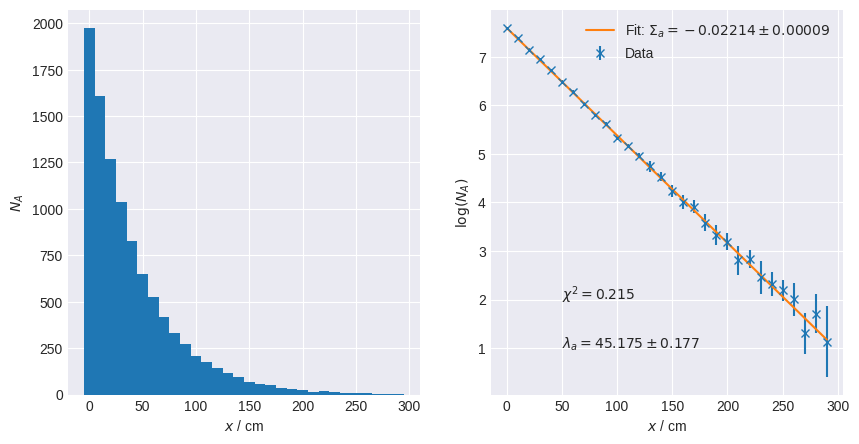

In [6]:
water_abs_att = 1/water_abs_csc

def reduced_chi_squared(observed, observed_errors, expected, parameters=2):
    """
    Function to calculate the reduced chi squared for a given fit.

    Parameters
    ----------
    observed: numpy array
        Array of observed data.
    observed_errors: numpy array
        Error on observed data.
    expected: numpy array
        Array of expected/fitting values.
    parameters: integer
        Number of parameters used during the fit. The default is 2.

    Returns
    -------
    reduced_chi_squared: float
        Reduced chi squared of the fit.
    """
    
    degrees_of_freedom = len(observed) - parameters
    chi_squared = np.sum(((observed - expected)/observed_errors)**2)
    reduced_chi_squared = chi_squared/degrees_of_freedom

    return reduced_chi_squared

# Initialise arrays for storing generated data.
water_exp_hist = np.zeros((10,30))
bin_edge = np.zeros((10,31))

# Obtaining 10 sets of data
for i in range(10):
    water_exp = exponential_generator(10000, water_abs_att)
    water_exp_hist[i], bin_edge[i] = np.histogram(water_exp, bins=30, range=(0,300))

mean_hist = np.mean(water_exp_hist, axis=0)
std_hist = np.std(water_exp_hist, axis=0)

log_hist = np.log(mean_hist)
log_err = np.abs(std_hist/mean_hist)

# Exclude final bin so data is same shape.
bin_edges = bin_edge[0][:-1]
para, cov = np.polyfit(bin_edges, log_hist, 1, w=1/log_err, cov=True)
errors = np.sqrt(np.diag(cov))

# Generate line from fitted parameters for plotting and chi squared
predicted_line = (bin_edges * para[0] + para[1])

bin_chi_squared = reduced_chi_squared(log_hist, log_err, predicted_line)

# Plotting
fig, (exponential_axis, line_axis) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram plots
exponential_axis.bar(bin_edges, mean_hist, width=10)
exponential_axis.set_ylabel("$N_A$")
exponential_axis.set_xlabel("$x$ / cm")

# Log plot with error bars
line_axis.errorbar(bin_edges, log_hist, yerr=log_err, fmt="x", label="Data")
line_axis.plot(bin_edges, predicted_line, label=rf"Fit: $\Sigma_a={para[0]:.5f} \pm {errors[0]:.5f}$")
line_axis.set_xlabel("$x$ / cm")
line_axis.set_ylabel(r"$\log(N_A)$")
line_axis.annotate(rf"$\chi^2 = {bin_chi_squared:.3f}$", xy=(50,2))
line_axis.annotate(rf"$\lambda_a = {-1/para[0]:.3f} \pm {errors[0]/(para[0]**2):.3f}$", xy=(50,1))
line_axis.legend()

plt.show()

We find that the generated data falls within a single standard deviation of the calculated values. This confirms that the generator we have written is valid.

## 2.5 Generating Radial Unit Vectors
When modelling scattering within our simulation, we will wish to choose a random direction for neutrons to be scattered. We could do this simply be generating a sete of points $(x_i, y_i, z_i)$, uniformly generating angles $\theta_i$ and $\phi_i$, and computing,

$$x_i = r\sin\theta_i\cos\phi_i$$
$$y_i = r\sin\theta_i\sin\phi_i$$
$$z_i = r\cos\theta_i$$

where $0 < \theta_i < \pi$ and $0 < \phi_i < 2\pi$, and $r$ is a constant length. However, if we were to choose $\theta_i$ uniformly in such a way, we would observe poles in our data. This occurs due to the varying radius of cross sections within the sphere, leading to a greater concentration of points at smaller radii. To alleviate this, we will generate $\theta_i$ according to,

$$\theta_i = \arccos(1-2u_i)$$

where $0 \leq u_i \leq 1$ is uniformly generated.

We will write a funciton which generates points in this way for a given $r$.

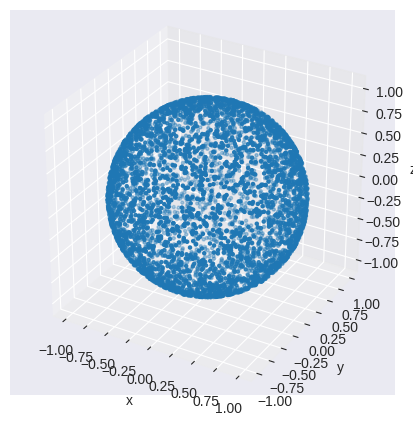

In [7]:
def unit_vector(r, samples):
    """
    Generates uniformly distributed points on a sphere of constant radius.
    
    Parameters
    ----------
    r: float
        Radius of the sphere. May be an array to generate multiple points.
    samples: integer
        Number of values generated

    Returns
    -------
    (x, y, z): tuple
        Tuple of points.
    """
    theta = np.arccos(1 - 2*np.random.uniform(size=samples))
    phi = np.random.uniform(low=0, high=np.pi*2, size=samples)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return (x,y,z)

x, y, z = unit_vector(1, 5000)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=5)

ax.set_box_aspect([1, 1, 1]) 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### 2.5.1 Visualising Steps
Let us now visalise a single, exponentially generated step in a random direction for each material. This will visualise the distance a particle can travel, beginning at the origin, before an interaction occurs.

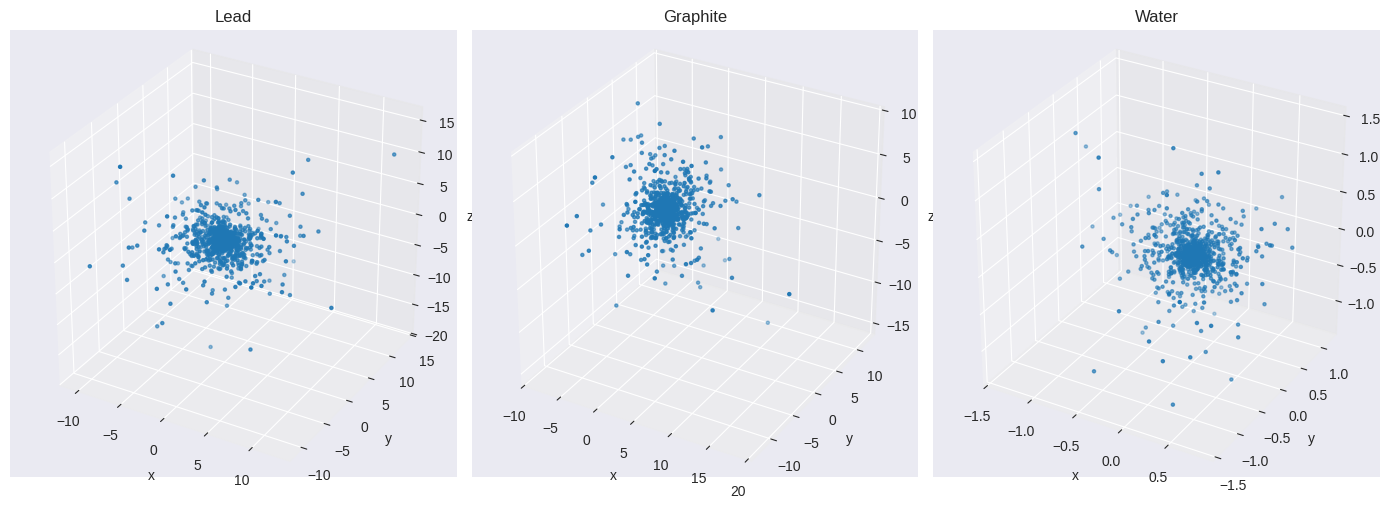

In [8]:
water_x, water_y, water_z = unit_vector(exponential_generator(1000, water_att), 1000)
lead_x, lead_y, lead_z = unit_vector(exponential_generator(1000, lead_att), 1000)
graphite_x, graphite_y, graphite_z = unit_vector(exponential_generator(1000, graphite_att), 1000)

fig = plt.figure(figsize=(14, 5))

materials = [
    ("Lead", lead_x, lead_y, lead_z),
    ("Graphite", graphite_x, graphite_y, graphite_z),
    ("Water", water_x, water_y, water_z),
]

# Looping over all materials and generating plots
for i, (label, x, y, z) in enumerate(materials, start=1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.scatter(x, y, z, s=5)
    ax.set_title(label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.show()

We see that lead and graphite produce steps with similar step lengths, with water having a significantly shorter step length than the former two materials. This makes sense, given the similar attenuation lengths of graphite and lead, and the much smaller attenuation length of water.

# 3. Visualising Random Walks
We can now begin to simulate the particle interactions which we are interested in. We will first visualise the random walk of a single particle through 10cm of each material. In order to simulate the processes we desire, we will employ a Markov-Chain Monte Carlo method. This will involve tracking a particle's "history" (i.e. its position) until an event which stops the simulation occurs. 

In our case, we are using a simple model wehre the only event we are concerned with is absorption. After each step of the simulation, we will generate a random number between 0 and 1 and compare it with the absorption probability. If this random number is less than the absoprtion probability, absorption occurs. The particle will be "killed" and the simulation ends. Otherwise, scattering will occur and we can generate a new, random step for the particle to take. We will also check whether the particle is reflected, or transmitted, at which point the simulation will also end.

We can calculate the absorption probability as described in section 1.3.

In [9]:
# Calculate absorption probability
p_a_water = water_abs_csc/(water_abs_csc + water_sca_csc)
p_a_lead = lead_abs_csc/(lead_abs_csc + lead_sca_csc)
p_a_graphite = graphite_abs_csc/(graphite_abs_csc + graphite_sca_csc)

probability_display_string = rf"""
|$P_A$ Water|$P_A$ Lead|$P_A$ Graphite|
|---|---|---|
|{p_a_water:.4f}|{p_a_lead:.4f}|{p_a_graphite:.4f}|
"""

markdown(probability_display_string)


|$P_A$ Water|$P_A$ Lead|$P_A$ Graphite|
|---|---|---|
|0.0064|0.0139|0.0009|


We will now write a function to simulate the path of a single particle.

In [10]:
def single_particle_simulation(p_a, thickness, attenuation_length, max_iter=10000):
    """
    Simulates the path of a single particle through a material using an exponential step distribution.

    Parameters
    ----------
    p_a : float
        Probability of absorption at each interaction.
    thickness : float
        Thickness of the material through which the particle travels.
    attenuation_length : float
        Mean free path of the particle in the medium.
    max_iter : int, optional
        Maximum number of steps the simulation runs for (default is 10000).

    Returns
    -------
    coordinate_matrix : array
        Matrix of 3D coordinates representing the particle's trajectory.
    end_state : str
        Final state of the particle: 'reflected', 'escaped', or 'absorbed'.
    """
    coordinate_matrix = np.zeros((max_iter, 3))
    coordinate_matrix[0][0] = -5  # Initial x-position outside the material
    coordinate_matrix[1][0] = np.abs(exponential_generator(1, attenuation_length))[0]  # First step into the material

    end_state = ""

    for i in range(1, max_iter - 1):
        current_pos = coordinate_matrix[i]

        if current_pos[0] < 0:
            end_state = "Reflected"
            break
        if current_pos[0] > thickness:
            end_state = "Escaped"
            break

        if np.random.uniform() <= p_a:
            end_state = "Absorbed"
            break

        step_length = exponential_generator(1, attenuation_length)[0]
        x, y, z = unit_vector(step_length, 1)
        direction = np.array([x[0], y[0], z[0]])

        coordinate_matrix[i + 1] = current_pos + direction

    return coordinate_matrix, end_state

water_single_particle, water_end_state = single_particle_simulation(p_a_water, 10, water_att)
lead_single_particle, lead_end_state = single_particle_simulation(p_a_lead, 10, lead_att)
graphite_single_particle, graphite_end_state = single_particle_simulation(p_a_graphite, 10, graphite_att)

Let's show this.

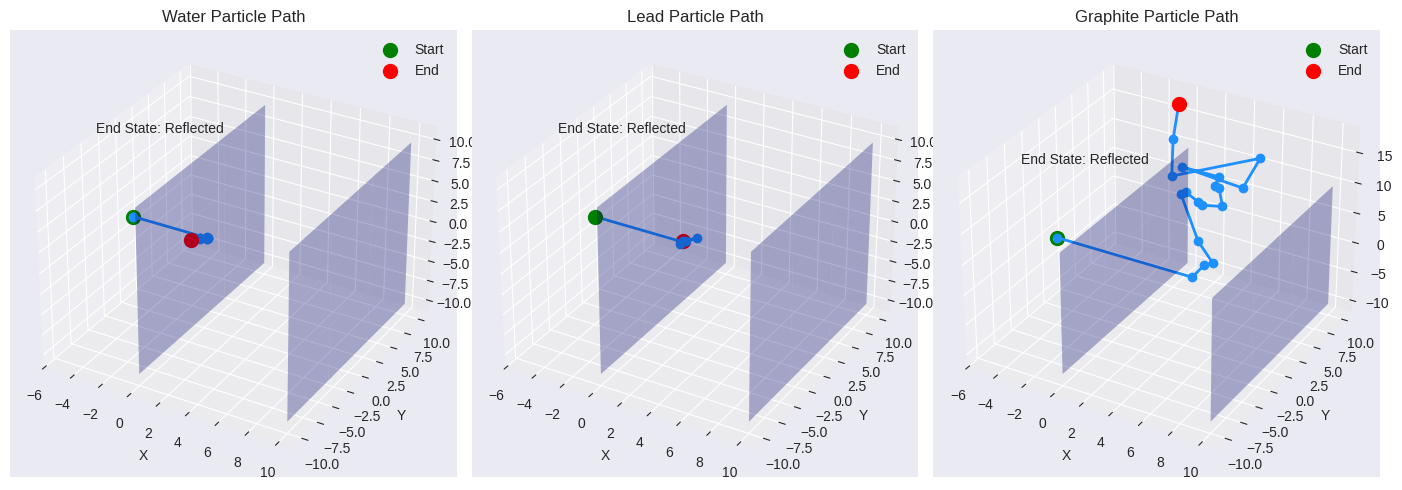

In [11]:
def plot_particle_path(ax, coordinate_matrix, end_state, title="Particle Path"):
    """
    Plots the 3D trajectory of a single particle within a simulated medium.

    Parameters
    ----------
    ax : matplotlib axis
        The 3D axes object on which the path is plotted.
    coordinate_matrix : array
        Matrix of 3D coordinates representing the particle's trajectory.
    end_state : string
        Final state of the particle: 'reflected', 'escaped', or 'absorbed'.
    title : str
        Title of the subplot. Default is "Particle Path".

    Returns
    -------
    None
    """
    
    # Filter out all-zero rows
    coords = coordinate_matrix[~np.all(coordinate_matrix == 0, axis=1)]
    
    x = coords[:, 0]
    y = coords[:, 1]
    z = coords[:, 2]

    ax.plot(x, y, z, marker='o', color='dodgerblue', linewidth=2)
    ax.scatter(x[0], y[0], z[0], color='green', s=100, label='Start')
    ax.scatter(x[-1], y[-1], z[-1], color='red', s=100, label='End')

    Y = np.linspace(-10, 10, 4)
    Z = np.linspace(-10, 10, 4)

    Y, Z = np.meshgrid(Y, Z)
    X_0 = np.zeros_like(Y)
    X_thick = np.full_like(Y, 10)

    ax.plot_surface(X_0, Y, Z, alpha=0.3, color='b')
    ax.plot_surface(X_thick, Y, Z, alpha=0.3, color='b')

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.text(-10,5,5, rf"End State: {end_state}")
    ax.legend()

# Create subplots
fig = plt.figure(figsize=(14, 5))
axs = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

# Plot each particle path
plot_particle_path(axs[0], water_single_particle, water_end_state, title="Water Particle Path")
plot_particle_path(axs[1], lead_single_particle, lead_end_state, title="Lead Particle Path")
plot_particle_path(axs[2], graphite_single_particle, graphite_end_state, title="Graphite Particle Path")

plt.tight_layout()
plt.show()

# 4. Quantifying Scattering Processes

We now wish to quantify the scattering process within each material, i.e., we want to obtain the transmission, escape, and reflection rates for each material. To do this, and to obtain appropriate errors, we must simulate the particle path through each material for a given number of particles, and repeat the simulation in order to obtain a standard deviation on each rate.

In order to make the process as efficient as possible, we must rewrite the simulation function to be more efficient. We can do this by no longer keeping track of particle history, and simply considering the current position of the particle.

In [12]:
particle_number = 10000

def n_particle_simulation(N, p_a, reps, thickness, attenuation_length, max_iter=10000):
    """
    Simulates the path of N particles through a given medium, counting the number of particles which are
    absorbed, reflected, or transmitted.

    Parameters
    ----------
    N: integer
        Number of particles.
    p_a: float
        Absorption probability.
    reps: float
        Number of times to repeat simulation.
    thickness: float
        Thickness of the slab in cm.
    attentuation_length: float
        Attentuation length of given material in cm.
    max_iter: int
        Maximum number of iterations for a given simulation. Default is 10000.

    Returns
    -------
    abs_counter: array
        Array of the number of particles absorbed in each simulation.
    ref_counter: array
        Array of the number of particles reflected in each simulation.
    esc_counter: array
        Array of the number of particles escaped in each simulation.
    """
    
    abs_counter = np.zeros(reps)
    ref_counter = np.zeros(reps)
    esc_counter = np.zeros(reps)

    for i in range(reps):
        position = np.zeros((N, 3))
        position[:, 0] = exponential_generator(N, attenuation_length)

        for _ in range(max_iter):
            if position.shape[0] == 0:
                break

            x_pos = position[:, 0]

            # Reflection
            reflect_mask = x_pos < 0
            ref_counter[i] += reflect_mask.sum()

            # Escape
            escape_mask = x_pos > thickness
            esc_counter[i] += escape_mask.sum()

            # Filter valid particles
            valid_mask = ~(reflect_mask | escape_mask)
            position = position[valid_mask]
            x_pos = x_pos[valid_mask]

            if position.shape[0] == 0:
                break

            # Absorption
            rand_abs = np.random.rand(position.shape[0])
            absorb_mask = rand_abs < p_a
            abs_counter[i] += absorb_mask.sum()

            position = position[~absorb_mask]

            if position.shape[0] == 0:
                break

            # Movement step
            M = position.shape[0]
            steps = exponential_generator(M, attenuation_length)
            x, y, z = unit_vector(1.0, M)
            direction = np.stack((x, y, z), axis=1)
            position += direction * steps[:, None]

    return abs_counter, ref_counter, esc_counter

# Running all simulations
water_matrix = n_particle_simulation(particle_number, p_a_water, 10, 10, water_att)
lead_matrix = n_particle_simulation(particle_number, p_a_lead, 10, 10, lead_att)
graphite_matrix = n_particle_simulation(particle_number, p_a_graphite, 10, 10, graphite_att)

# Taking mean and standard deviation for each material
water_mean = np.mean(water_matrix, axis=1)/particle_number
water_std = np.std(water_matrix, axis=1)/particle_number
lead_mean = np.mean(lead_matrix, axis=1)/particle_number
lead_std = np.std(lead_matrix, axis=1)/particle_number
graphite_mean = np.mean(graphite_matrix, axis=1)/particle_number
graphite_std = np.std(graphite_matrix, axis=1)/particle_number

In [13]:
materials = [
    ("Water", water_mean, water_std),
    ("Lead", lead_mean, lead_std),
    ("Graphite", graphite_mean, graphite_std)
]

labels = ["Absorbed", "Reflected", "Escaped"]
colors = ["#1f77b4",  "#ff7f0e", "#2ca02c",]

x = np.arange(len(labels))

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

for i, (title, mean, std) in enumerate(materials):
    bars = axes[i].bar(x, mean, yerr=std, capsize=5, color=colors)
    axes[i].set_title(title)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("Fraction")
    axes[i].grid(True, linestyle='--', alpha=0.5)
    
    # Annotate each bar with value +/- error in percentage
    for j, bar in enumerate(bars):
        height = bar.get_height()
        error = std[j]
        percent_str = f"{height*100:.2f} ± {error*100:.2f}%"
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.02, percent_str,
                     ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

NameError: name 'labels' is not defined

We can see that, for a slab of thickness 10cm, water seems to be the best material for shielding against neutrons, yielding the lowest escape rate out of each material. The reflection and escape rate of lead and graphite are quite similar, as can be expected from their similar mean free path, however lead is a greater absorber of neutrons, as was expected due to lead's greater absorption cross section.

# 5. Variation of Thickness

We will now analyse the absorption, reflection, and transmission rates of neutrons within all materials as we vary the thickness of the slab, from 1cm to 15cm.

In [ ]:
thickness_array = np.arange(1, 16, 1, dtype=int)

water = np.empty(shape=(15,2,3))
lead = np.empty(shape=(15,2,3))
graphite = np.empty(shape=(15,2,3))

sim_start = time.time()
f = IntProgress(min=0, max=15)
display(f)
for i, thickness in enumerate(thickness_array):
    water_sim = n_particle_simulation(particle_number, p_a_water, 10, thickness, water_att)
    lead_sim = n_particle_simulation(particle_number, p_a_lead, 10, thickness, lead_att)
    graphite_sim = n_particle_simulation(particle_number, p_a_graphite, 10, thickness, graphite_att)
    water[i][0] = np.mean(water_sim, axis=1)/particle_number
    water[i][1] = np.std(water_sim, axis=1)/particle_number
    
    lead[i][0] = np.mean(lead_sim, axis=1)/particle_number
    lead[i][1] = np.std(lead_sim, axis=1)/particle_number
    
    graphite[i][0] = np.mean(graphite_sim, axis=1)/particle_number
    graphite[i][1] = np.std(graphite_sim, axis=1)/particle_number
    f.value += 1
markdown(f"Simulation finished in {time.time() - sim_start:.2f} seconds.")

## 5.1. Water

In [ ]:
fig, (water_abs, water_ref, water_esc) = plt.subplots(1,3, figsize=(14,5))

water_abs.errorbar(thickness_array, water[:,0,0], yerr=water[:,1,0], fmt="-x")
water_abs.set_title("Absorption with varying thickness")
water_abs.set_ylabel("$N_{A}/N$")
water_abs.set_xlabel("Thickness / cm")

water_ref.errorbar(thickness_array, water[:,0,1], yerr=water[:,1,1], fmt="-x")
water_ref.set_title("Reflection with varying thickness")
water_ref.set_ylabel("$N_{R}/N$")
water_ref.set_xlabel("Thickness / cm")

water_esc.errorbar(thickness_array, water[:,0,2], yerr=water[:,1,2], fmt="-x")
water_esc.set_title("Escape with varying thickness")
water_esc.set_ylabel("$N_{E}/N$")
water_esc.set_xlabel("Thickness / cm")
plt.tight_layout()

As thickness of the slab increases, we find that the rate of absorption and reflection increases rapdibly, before plateauing at ~20% and ~80% respectively. We find that the rate of escape of neutrons falls rapdily, and seemingly exponentially, with increasing thickness, almost approaching 0.

## 5.2. Lead

In [ ]:
fig, (lead_abs, lead_ref, lead_esc) = plt.subplots(1,3, figsize=(14,5))

lead_abs.errorbar(thickness_array, lead[:,0,0], yerr=lead[:,1,0], fmt="-x")
lead_abs.set_title("Absorption with varying thickness")
lead_abs.set_ylabel("$N_{A}/N$")
lead_abs.set_xlabel("Thickness / cm")

lead_ref.errorbar(thickness_array, lead[:,0,1], yerr=lead[:,1,1], fmt="-x")
lead_ref.set_title("Reflection with varying thickness")
lead_ref.set_ylabel("$N_{R}/N$")
lead_ref.set_xlabel("Thickness / cm")

lead_esc.errorbar(thickness_array, lead[:,0,2], yerr=lead[:,1,2], fmt="-x")
lead_esc.set_title("Escape with varying thickness")
lead_esc.set_ylabel("$N_{E}/N$")
lead_esc.set_xlabel("Thickness / cm")
plt.tight_layout()

In lead, we find that the absorption rate increases nearly linearly with increasing thickness. The rate of reflection rises similarly to water, however much more slowly. The escape rate in lead is also similar to water, however the decrease in the number of neutrons escaped is much slower, and never reaches 0. 

## 5.3. Graphite

In [ ]:
fig, (graphite_abs, graphite_ref, graphite_esc) = plt.subplots(1,3, figsize=(14,5))

graphite_abs.errorbar(thickness_array, graphite[:,0,0], yerr=graphite[:,1,0], fmt="-x")
graphite_abs.set_title("Absorption with varying thickness")
graphite_abs.set_ylabel("$N_{A}/N$")
graphite_abs.set_xlabel("Thickness / cm")

graphite_ref.errorbar(thickness_array, graphite[:,0,1], yerr=graphite[:,1,1], fmt="-x")
graphite_ref.set_title("Reflection with varying thickness")
graphite_ref.set_ylabel("$N_{R}/N$")
graphite_ref.set_xlabel("Thickness / cm")

graphite_esc.errorbar(thickness_array, graphite[:,0,2], yerr=graphite[:,1,2], fmt="-x")
graphite_esc.set_title("Escape with varying thickness")
graphite_esc.set_ylabel("$N_{E}/N$")
graphite_esc.set_xlabel("Thickness / cm")
plt.tight_layout()

Graphite seems to have greater fluctuations in absorption rates compared to water and lead as indicated by the large error bars in the data. This is likely due to the very low absorption cross section for graphite. The behaviour of reflection and escape for graphite is very similar to that of lead, as expected due to their similar mean free path.  

## 5.4. Characteristic Attenuation Length
Using the data from the simulation above, we can estimate the characteristic attenuation length for each material. We can do this by taking a log on the escape rate data, and fitting it to a straight line, as we did previously when considering an infinite slab of water in section 2.4.1. The data will be fitted using the `polyfit` algorithm, with a weight of repiprocal of the error on the data.

In [ ]:
# Log of transmitted data
log_water_trans = np.log(water[:,0,2])
log_lead_trans = np.log(lead[:,0,2])
log_graphite_trans = np.log(graphite[:,0,2])

# Error on logged transmitted data
log_error_water = np.abs(water[:,1,2]/water[:,0,2]) 
log_error_lead = np.abs(lead[:,1,2]/lead[:,0,2]) 
log_error_graphite = np.abs(graphite[:,1,2]/graphite[:,0,2])

# Performing fit on water
water_para, water_cov = np.polyfit(thickness_array, log_water_trans, 1, w = 1/log_error_water, cov=True)
water_error = np.sqrt(np.diag(water_cov))
water_line = thickness_array*water_para[0] + water_para[1]
water_chi_squared = reduced_chi_squared(log_water_trans, log_error_water, water_line)

# Performing fit on lead
lead_para, lead_cov = np.polyfit(thickness_array, log_lead_trans, 1, w = 1/log_error_lead, cov=True)
lead_error = np.sqrt(np.diag(lead_cov))
lead_line = thickness_array*lead_para[0] + lead_para[1]
lead_chi_squared = reduced_chi_squared(log_lead_trans, log_error_lead, lead_line)

# Performing fit on graphite
graphite_para, graphite_cov = np.polyfit(thickness_array, log_graphite_trans, 1, w = 1/log_error_graphite, cov=True)
graphite_error = np.sqrt(np.diag(graphite_cov))
graphite_line = thickness_array*graphite_para[0] + graphite_para[1]
graphite_chi_squared = reduced_chi_squared(log_graphite_trans, log_error_graphite, graphite_line)

# Plotting
fig, (att_water, att_lead, att_graphite) = plt.subplots(1,3, figsize=(16,5))

# Water plot
att_water.errorbar(thickness_array, log_water_trans, yerr=log_error_water, fmt="x")
att_water.plot(thickness_array, water_line, label=rf"Fit: $\lambda = ({-1/water_para[0]:.3f} \pm {water_error[0]/(water_para[0]**2):.3f})$cm")
att_water.annotate(rf"$\chi_R^2 = {water_chi_squared:.3f}$", xy = (2,-8))

# Lead plot
att_lead.errorbar(thickness_array, log_lead_trans, yerr=log_error_lead, fmt="x")
att_lead.plot(thickness_array, lead_line, label=rf"Fit: $\lambda = ({-1/lead_para[0]:.3f} \pm {lead_error[0]/(lead_para[0]**2):.3f})$cm")
att_lead.annotate(rf"$\chi_R^2 = {lead_chi_squared:.3f}$", xy = (2,-1.75))

# Graphite plot
att_graphite.errorbar(thickness_array, log_graphite_trans, yerr=log_error_graphite, fmt="x")
att_graphite.plot(thickness_array, graphite_line, label=rf"Fit: $\lambda = ({-1/graphite_para[0]:.3f} \pm {graphite_error[0]/(graphite_para[0]**2):.3f})$cm")
att_graphite.annotate(rf"$\chi_R^2 = {graphite_chi_squared:.3f}$", xy = (2,-1.6))

att_water.legend()
att_graphite.legend()
att_lead.legend()

The data obtained from the simulation is clearly not well described by our simple model, as indicated by the high $\chi_R^2$ on all our fittings. This may be due to not accounting for other contributing errors in the simulation. It may also be due to not accounting for non-linearities or other processes ocurring within the material. 

The model we employed considered only elastic collisions between neutrons and nuclei within the medium. Neutrons within the medium would undergo inelastic collisions with the molecules and nuclei within the material, such that when a neutron collided with a nucleus, it would lose some energy as it scattered, and excite the nucleus. This would be most present in graphite, due to its use in moderating neutrons.

# 6. Extension: Woodcock Method

We now wish to analyse the behaviour of neutrons when we have two materials placed together. The above methods worked well because we had simple geometries. However, when dealing with more complicated geometries, such as having materials at boundaries 

In order to simulate this and to avoid computationally heavy analysis, we employ the *Woodcock method*, also known as fictitious tracking. It works like this:

- Choose a *majorant cross-section*, i.e., $$\Sigma_T = \text{max}(\Sigma_1, \Sigma_2).$$
- Take a step according to that cross-section, $$s_i =-\lambda_T\log(u_i).$$

This process avoids having to track the neutron across various materials at different distances. One may notice that when in a material with a smaller cross section, we end up taking steps which are too short. To overcome this, the neutron will take *fictitious steps*. This involves taking multiple steps in the same direction. In order to determine whether a step is fictitious or not, we must consider the probability that a neutron is in the majorant cross section,

$$P\left[f\right] = \frac{\Sigma_f}{\Sigma_T} = \frac{\Sigma_T - \Sigma_C}{\Sigma_T} = 1 - \frac{\Sigma_C}{\Sigma_T}$$

where $\Sigma_C$ is the is the cross section of the material the neutron is currently in. We can then determine whether a step is fictitious by generating a random number $\nu$ and checking the condition,

$$\nu > \frac{\Sigma_C}{\Sigma_T}.$$

If the step is not fictitious, we continue the simulation as previous, checking for absorption and changing the particle step.

Let us write a function which will perform the Woodcock method, from which we can obtain absorption, reflection, and escape rates.

In [ ]:
def woodcock(N, p_a, reps, thickness, csc, max_iter=10000):
    """
    Implementation of the Woodcock method for two adjacent materials of different thickness.

    Parameters
    ----------
    N: integer
        Number of particles to simulate.
    p_a: array
        Array of absorption probabilities for each material.
    reps: integer
        Number of times to repeat the simulation.
    csc: array
        Array of macroscopic cross sections for each material.
    max_iter: integer
        Maximum number of iterations for each simulation. Default is 10000.

    Returns
    -------
    [abs_counter, ref_counter, esc_counter]: array
        abs_counter: integer
            Number of particles absorbed.
        ref_counter: integer
            Number of particles reflected.
        esc_counter: integer
            Number of particles escaped.
    """

    # Initialise arrays.
    abs_counter = np.zeros(reps)
    ref_counter = np.zeros(reps)
    esc_counter = np.zeros(reps)

    # Compute values required for simulation.
    total_thickness = np.sum(thickness)
    majorant_csc = np.max(csc)
    att_length = 1 / majorant_csc

    # Precompute layer condition.
    total_csc = np.sum(csc)
    prob_layer = [c / total_csc for c in csc]

    for i in range(reps):
        # Initialise position matrix and initial direction.
        position = np.zeros((N, 3))
        position[:, 0] = exponential_generator(N, att_length)
        direction = np.tile([1.0, 0.0, 0.0], (N, 1))

        # Loop until max_iter
        for _ in range(max_iter):
            alive = len(position)
            if alive == 0: # End simulation if no more particles left.
                break

            x_pos = position[:, 0]

            # Count reflected particles
            reflect_mask = x_pos < 0
            num_reflect = np.count_nonzero(reflect_mask)
            ref_counter[i] += num_reflect

            # Count escaped particles
            escape_mask = x_pos > total_thickness
            num_escape = np.count_nonzero(escape_mask)
            esc_counter[i] += num_escape

            # Create mask of all remaining particles
            alive_mask = ~(reflect_mask | escape_mask)
            if not np.any(alive_mask): # If no particles alive, end simulation
                break

            # Update position and direction
            position = position[alive_mask]
            direction = direction[alive_mask]
            x_pos = position[:, 0]

            # Count absorbed particles
            absorption_rand = np.random.uniform(size=len(position))
            in_layer0 = x_pos <= thickness[0]
            in_layer1 = x_pos > thickness[0]

            absorb_mask = (in_layer0 & (absorption_rand < p_a[0])) | \
                          (in_layer1 & (absorption_rand < p_a[1]))
            abs_counter[i] += np.sum(absorb_mask)

            alive_mask = ~absorb_mask
            if not np.any(alive_mask): # If no particles alive, end simulation
                break

            # Update position and reflection
            position = position[alive_mask]
            direction = direction[alive_mask]
            x_pos = position[:, 0]

            # Determine real vs. fictitious steps
            nu = np.random.uniform(size=len(position))
            curr_layer = np.where(x_pos <= thickness[0], 0, 1)
            is_real = nu <= np.array(prob_layer)[curr_layer]

            # Generate fictitious steps
            fict_idx = np.where(~is_real)[0]
            position[fict_idx] += exponential_generator(len(fict_idx), att_length)[:, None] * direction[fict_idx]

            # Generate real steps
            real_idx = np.where(is_real)[0]
            step_real = exponential_generator(len(real_idx), att_length)
            x, y, z = unit_vector(r=1.0, samples=len(real_idx))
            new_dirs = np.stack((x, y, z), axis=1)
            direction[real_idx] = new_dirs
            position[real_idx] += step_real[:, None] * new_dirs

    return np.array([abs_counter, ref_counter, esc_counter])

## 6.1. Sanity Check
Let us verify that the Woodcock method is consistent with the Monte-Carlo method by performing a simulation with a layer of water of 10cm, next to a layer of 0 thickness with the properties of vacuum.

In [ ]:
woodcock_water_sim = woodcock(10000, [p_a_water, 0], 10, [10, 0], [water_csc, 1e-99])

woodcock_abs, woodcock_ref, woodcock_esc = np.mean(woodcock_water_sim, axis=1)/100
woodcock_abs_err, woodcock_ref_err, woodcock_esc_err = np.std(woodcock_water_sim, axis=1)/100

woodcock_display_string = rf"""
|Absorbed|Reflected|Escaped|
|---|---|---|
|{woodcock_abs:.3f} $\pm$ {woodcock_abs_err:.3f}%|{woodcock_ref:.3f} $\pm$ {woodcock_ref_err:.3f}%|{woodcock_esc:.3f} $\pm$ {woodcock_esc_err:.3f}%|
"""

markdown(woodcock_display_string)

These values are consistent to within a standard deviation of the values obtained via the Monte Carlo simulation. We can confirm that the Woodcock method produces reasonable results, aand proceed with the simulation. 

## 6.2. Quantifying Scattering Process of Combined Materials
We may then proceed to analyse the absorption, transmission and reflection rates of different combinations of materials. We will combine 5cm of each material and observe if there is any variation in behaviour of the neutrons.

In [ ]:
particle_number = 5000

water_lead = woodcock(particle_number, [p_a_water, p_a_lead], 10, [5,5], [water_csc, lead_csc])
water_graphite = woodcock(particle_number, [p_a_water, p_a_graphite], 10, [5,5], [water_csc, graphite_csc])
lead_graphite = woodcock(particle_number, [p_a_lead, p_a_graphite], 10, [5,5], [lead_csc, graphite_csc])
lead_water = woodcock(particle_number, [p_a_lead, p_a_water], 10, [5,5], [lead_csc, water_csc])
graphite_water = woodcock(particle_number, [p_a_graphite, p_a_water], 10, [5,5], [graphite_csc, water_csc])
graphite_lead = woodcock(particle_number, [p_a_graphite, p_a_lead], 10, [5,5], [graphite_csc, lead_csc])

water_lead_mean = np.mean(water_lead, axis = 1)/particle_number
water_lead_error = np.std(water_lead, axis = 1)/particle_number

water_graphite_mean = np.mean(water_graphite, axis = 1)/particle_number
water_graphite_error = np.std(water_graphite, axis = 1)/particle_number

lead_graphite_mean = np.mean(lead_graphite, axis = 1)/particle_number
lead_graphite_error = np.std(lead_graphite, axis = 1)/particle_number

lead_water_mean = np.mean(lead_water, axis = 1)/particle_number
lead_water_error = np.std(lead_water, axis = 1)/particle_number

graphite_water_mean = np.mean(graphite_water, axis = 1)/particle_number
graphite_water_error = np.std(graphite_water, axis = 1)/particle_number

graphite_lead_mean = np.mean(graphite_lead, axis = 1)/particle_number
graphite_lead_error = np.std(graphite_lead, axis = 1)/particle_number

Let's now display these rates.

In [ ]:
# Names for outcome categories
labels = ["Absorbed", "Reflected", "Escaped"]
x = np.arange(len(labels))

# Data and errors for each material pair
data = [
    ("Water-Lead", water_lead_mean, water_lead_error),
    ("Water-Graphite", water_graphite_mean, water_graphite_error),
    ("Lead-Graphite", lead_graphite_mean, lead_graphite_error),
    ("Lead-Water", lead_water_mean, lead_water_error),
    ("Graphite-Water", graphite_water_mean, graphite_water_error),
    ("Graphite-Lead", graphite_lead_mean, graphite_lead_error),
]

# Plot setup
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

# Create bar charts with error bars and percentages
for i, (title, mean, error) in enumerate(data):
    bars = axes[i].bar(x, mean, yerr=error, capsize=5, color=colors)
    axes[i].set_title(title)
    axes[i].set_ylim(0, 1)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels)
    axes[i].set_ylabel("Fraction of Particles")
    axes[i].grid(True, linestyle='--', alpha=0.5)

    # Annotate bars with percentage +/ error
    for j, bar in enumerate(bars):
        height = bar.get_height()
        err = error[j]
        axes[i].text(
            bar.get_x() + bar.get_width()/2,
            height + 0.02,
            f"{height*100:.2f} ± {err*100:.2f}%",
            ha='center',
            va='bottom',
            fontsize=8,
            rotation=90
        )

plt.tight_layout()
plt.show()

We can see that the water-lead and water-graphite and graphite-water material combinations effectively behave as water. Lead-graphite and graphite-lead material combinations seem to have the poorest outcomes in regards to neutron shielding, given their very high escape rates. However, the lead-water material combination seems to be the most promising, having the highest absorption rates out of all materials, while maintaining a low escape rate.

# 7. Conclusion
Monte-Carlo methods have a wide use within modern physics. This project utilised Monte-Carlo methods to simulate trajectories of neutrons, and processes which occur in water, graphite, and lead. The simulation found that water is the material most capable of neutron shielding due to its low (<1%) escape rates, as was expected from its high neutron absorption and scattering cross section. Graphite was found to have the highest escape rate out of all three materials, as was expected due to its low absorption and scattering cross sections. Further simulations were performed to obtain the characteristic attenuation length of each material, however this was unsuccessful due to the low quality of fit on each plot. This may have been due to unaccounted for factors during the simulation, such as other absorption proccesses or improper handling of energy exchange. Further simulations were performed to analyse the trajectory of neutrons within a layer composed of two different adjacent materials using the Woodcock method. It was found that material combinations with water in the initial layer behaved, effectively, like water, while graphite-lead and lead-graphite material were found to have the highest escape rates out of all combinations. The most interesting material combination was lead-water, which produced a relatively low escape rate, while having the greatest absorption rate out of all combinations. Within a nuclear reactor, this type of material combination could be utlised as an intermediary layer, absorbing any neutrons which are not reflected back into the core of the reactor.

In [ ]:
markdown(f"Time to finish project: {time.time() - s} seconds.")

# References 
<a name="cite_note-1"></a>1. [^](#cite_ref-1) : Eckhardt, R. (1987). "Stan Ulam, John von Neumann, and the Monte Carlo method". Los Alamos Science (15): 131–137.

<a name="cite_note-2"></a>2. [^](#cite_ref-2) : Abdulrahman, S. T., Ahmad, Z., Thomas, S., & Rahman, A. A. (2020). Introduction to neutron-shielding materials. In Micro and nanostructured composite materials for neutron shielding applications (pp. 1-23). Woodhead Publishing.

<a name="cite_note-3"></a>3. [^](#cite_ref-3) : Alemberti, A., Smirnov, V., Smith, C. F., & Takahashi, M. (2014). Overview of lead-cooled fast reactor activities. Progress in Nuclear Energy, 77, 300-307.

<a name="cite_note-4"></a>4.[^](#cite_ref-4) : Lamarsh, J. R., & Baratta, A. J. (2001). Introduction to Nuclear Engineering (3rd ed.). Prentice Hall.

<a name="cite_note-5"></a>5. [^](#cite_ref-5) : Marsaglia, G. (September 1968). "Random Numbers Fall Mainly in the Planes". PNAS. 61 (1): 25–28. 

<a name="cite_note-6"></a>6. [^](#cite_ref-6): Knuth, D. E. (1981), "3.3.4: The Spectral Test", The Art of Computer Programming volume 2: Seminumerical algorithms (2nd ed.), Addison-Wesley.